# Installs

In [1]:
# !pip install -U onetick-ds-framework==0.0.78.dev3
# !pip install -U onetick.py

# Imports

In [2]:
import os
import yaml
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from dsframework.utils import build_experiment
import onetick.py as otp

import dsframework
dsframework.__version__

'0.0.78.dev3'

# Mini Use Cases

## 1. Simple Experiment run

In [3]:
# initialize the experiment from a config file
config_path = os.path.join('./min_config.yml')
config = yaml.load(open(config_path), Loader=yaml.Loader)
exp = build_experiment(config)

# get data
df_orig = exp.get_data()

# prepare the data for training a model
exp.prepare_data()

# train the model
exp.init_fit()

# get predictions
prediction = exp.predict(x = exp.x_test)
print(prediction)

# compute evaluation metrics
exp.calc_metrics()

2022-10-18 15:53:39,930	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:53:39,931	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver
2022-10-18 15:53:44,158	WARNING pool.py:591 -- The 'context' argument is not supported using ray. Please refer to the documentation for how to control ray initialization.


      VOLUME_PREDICTION
8500        3219.517167
8501        3290.336307
8502        3960.126890
8503        3550.233217
8504        3264.060974
...                 ...
9995        4917.167677
9996        4711.400270
9997        4174.801680
9998        4371.004288
9999        4081.390862

[1500 rows x 1 columns]


{'VOLUME_MAE': 480.3120285597973}

## 2. Hyperparameter optimization

There are 2 ways to configure hyperparameter tuning:


    a) modify yaml file directly (enable hyperparameter tuning and specify lists of parameter values):

    ```
    training:
        use: 'CatBoostRegressor'
        search_cv:
          search_optimization: 'grid' # 'none', 'grid', 'random'
        models:
          CatBoostRegressor:
            init_params:
              iterations: [ 500 ]
              learning_rate: [ 0.09 ]
              l2_leaf_reg: [ 1, 2, 3 ]
              depth: [ 1, 2 ]
            fit_params:
              verbose: 0
    ```
    
    b) modify config after loading from yaml file:
    
    ```
    config['training']['search_cv']['search_optimization'] = 'grid'
    config['training']['models']['CatBoostRegressor']['init_params'] = {'iterations': [ 500 ],
                                                                        'learning_rate': [ 0.09 ],
                                                                        'l2_leaf_reg': [ 1, 2, 3 ],
                                                                        'depth': [ 1, 2 ]}


In [4]:
# Example with the modifying init_params_grid parameter in the init_fit function:

config_path = os.path.join('./demo_config.yml')
config = yaml.load(open(config_path), Loader=yaml.Loader)

config['training']['search_cv']['search_optimization'] = 'grid'
config['training']['models']['CatBoostRegressor']['init_params'] = {'iterations': [ 500 ],
                                                                    'learning_rate': [ 0.09 ],
                                                                    'l2_leaf_reg': [ 1, 2, 3 ],
                                                                    'depth': [ 1, 2 ]}
exp = build_experiment(config)

exp.get_data()
exp.prepare_data()


exp.init_fit()

# output the best parameters
exp.current_model_params

2022-10-18 15:53:54,411	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:53:54,412	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver


{'depth': 2, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.09}

## 3. Choosing ML model

The model to be used is defined in the `training` section of the config and enabled by setting the `use` parameter to the model name.

Note that we can avoid retrieving data multiple times by passing it to the `prepare_data()` function for different models:

```
df = exp.get_data()

...

exp.prepare_data(df=df)
```

In [5]:
# Let's list the set of models that we want to test
models = ['XGBRegressor', 'CatBoostRegressor', 'DNNRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor']

config_path = os.path.join('./min_config.yml')
config = yaml.load(open(config_path), Loader=yaml.Loader)
exp = build_experiment(config)


df = exp.get_data()

# Calculate metrics for each model
res = {}
for model in models:
    config['training']['use'] = model
    exp = build_experiment(config)
    exp.prepare_data(df=df)
    exp.init_fit()
    exp.predict(x = exp.x_test)
    res[f'{model}'] = exp.calc_metrics()
    
res

2022-10-18 15:54:07,793	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:54:07,794	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver
2022-10-18 15:54:19,119	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:54:19,120	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver
2022-10-18 15:54:34.847304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64/:
2022-10-18 15:54:34.847335: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-18 15:54:35,887	INFO worker.py:1223 -- Using address ray:

47/47 [==============================] - 0s 503us/step


2022-10-18 15:55:01,480	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:55:01,481	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver
2022-10-18 15:55:13,288	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:55:13,289	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver


{'XGBRegressor': {'VOLUME_MAE': 508.0396787923177},
 'CatBoostRegressor': {'VOLUME_MAE': 480.3120285597973},
 'DNNRegressor': {'VOLUME_MAE': 4317.029482058208},
 'DecisionTreeRegressor': {'VOLUME_MAE': 655.1166666666667},
 'RandomForestRegressor': {'VOLUME_MAE': 512.1501999999999}}

## 4. Choosing data preprocessing 

The preprocessors to be used are defined in the `preprocessors` section. The use of each preprocessor can be enabled or disabled by setting the `use` parameter (True/False).

In [6]:
config_path = os.path.join('./demo_config.yml')
config = yaml.load(open(config_path), Loader=yaml.Loader)
exp = build_experiment(config)
df = exp.get_data()

# Calculate metrics for each combination of data processing
res = {}
for preproc_combination in list(itertools.product([False, True], [False, True])):
    key = []
    for idx, preprocessor in enumerate(config['preprocessors']):
        preprocessor['use'] = preproc_combination[idx]
        key.append(f"{preprocessor['class']} = {preproc_combination[idx]}")  
    exp = build_experiment(config)
    exp.prepare_data(df=df)
    exp.init_fit()
    exp.predict(x = exp.x_test)
    res[tuple(key)] = exp.calc_metrics()
    
res

2022-10-18 15:55:31,821	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:55:31,822	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver
2022-10-18 15:55:45,772	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:55:45,773	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver
2022-10-18 15:55:57,109	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:55:57,110	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver
2022-10-18 15:56:12,541	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:56:12,542	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the se

{('dsframework.impl.LimitOutliers = False',
  'dsframework.impl.IntradayAveraging = False'): {'VOLUME_MAPE': 0.11019883220775456},
 ('dsframework.impl.LimitOutliers = False',
  'dsframework.impl.IntradayAveraging = True'): {'VOLUME_MAPE': 0.11629398269108131},
 ('dsframework.impl.LimitOutliers = True',
  'dsframework.impl.IntradayAveraging = False'): {'VOLUME_MAPE': 0.10998341256526235},
 ('dsframework.impl.LimitOutliers = True',
  'dsframework.impl.IntradayAveraging = True'): {'VOLUME_MAPE': 0.11590244456856563}}

## 5. Selecting features

The features to be used are defined in the `features` section. Features can be reconfigured or new ones added (see also example #9).

In [7]:
config_path = os.path.join('./demo_config.yml')
config = yaml.load(open(config_path), Loader=yaml.Loader)
exp = build_experiment(config)
df = exp.get_data()

# Calculate metrics for each set of lag features
res = {}
for i in range(2, 12):
    lags = list(range(1, i))
    config['features'][0]['periods'] = lags
    exp = build_experiment(config)
    exp.prepare_data(df=df)
    exp.init_fit()
    exp.predict(x = exp.x_test)
    res[f'lags: {str(lags)}'] = exp.calc_metrics()

res

2022-10-18 15:56:30,036	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:56:30,037	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver
2022-10-18 15:56:44,392	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:56:44,393	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver
2022-10-18 15:56:59,177	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:56:59,178	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver
2022-10-18 15:57:13,565	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:57:13,566	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the se

{'lags: [1]': {'VOLUME_MAPE': 0.1160511459691753},
 'lags: [1, 2]': {'VOLUME_MAPE': 0.11600225410878359},
 'lags: [1, 2, 3]': {'VOLUME_MAPE': 0.11549145754798167},
 'lags: [1, 2, 3, 4]': {'VOLUME_MAPE': 0.11772749110258389},
 'lags: [1, 2, 3, 4, 5]': {'VOLUME_MAPE': 0.11614028232784115},
 'lags: [1, 2, 3, 4, 5, 6]': {'VOLUME_MAPE': 0.11640921832039126},
 'lags: [1, 2, 3, 4, 5, 6, 7]': {'VOLUME_MAPE': 0.11530508542476009},
 'lags: [1, 2, 3, 4, 5, 6, 7, 8]': {'VOLUME_MAPE': 0.11790208644913347},
 'lags: [1, 2, 3, 4, 5, 6, 7, 8, 9]': {'VOLUME_MAPE': 0.11563472296758968},
 'lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]': {'VOLUME_MAPE': 0.11636864576470511}}

## 6. Test of various types of validation

There are 2 ways to configure validation:

    a) modify yaml-file directly:

    ```
    training:
        use: 'CatBoostRegressor'
        search_cv:
            val_type: 'Simple' # 'Simple', 'Cross', 'WalkForward'
            folds: 5 # is used for 'Cross', 'WalkForward'
            eval_metric: 'MAE'
    ```
    
    b) modify config after loading from yaml file:
    
    ```
    config['training']['search_cv']['val_type'] = 'WalkForward'

    ```


In [ ]:
# Example with modifying training_params in the init_fit function:

config_path = os.path.join('./demo_config.yml')
config = yaml.load(open(config_path), Loader=yaml.Loader)

config['training']['search_cv']['val_type'] = 'WalkForward'

exp = build_experiment(config)

exp.get_data()
exp.prepare_data()

# Let's save the current training parameters, and change only search_cv subsection.
exp.init_fit()

exp.cv_model.cv_results_

## 7. Benchmark: current prediction = previous actual

It is possible to calculate metrics for a simple model like `"the current predicted value is equal to the previous actual value"` in order to evaluate the performance of an ML model.

In [9]:
config_path = os.path.join('./min_config.yml')
config = yaml.load(open(config_path), Loader=yaml.Loader)
exp = build_experiment(config)

exp.get_data()
exp.prepare_data()
exp.init_fit()
exp.predict(x = exp.x_test)

model_metric = exp.calc_metrics()
baseline_metric = exp.calc_baseline()

'ML model metrics', model_metric, 'Baseline model metrics', baseline_metric

2022-10-18 15:59:30,036	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:59:30,037	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver


('ML model metrics',
 {'VOLUME_MAE': 480.3120285597973},
 'Baseline model metrics',
 {'VOLUME_MAE': 487.4316210807205})

## 8. Train models for various instruments

The datafeeds to be used is defined in the `datafeeds` section. Datafeeds can be reconfigured or new ones added.

In [10]:
config_path = os.path.join('./demo_config.yml')
config = yaml.load(open(config_path), Loader=yaml.Loader)

config['datafeeds'][0] = {
    'class': 'dsframework.impl.EquitiesOneTickData',
    'use': True,
    'db': 'NYSE_TAQ',
    'tick_type': 'TRD',
    'symbols': [ 'V' ],
    'start': [2022, 2, 1, 9, 30],
    'end': [2022, 4, 1, 16, 0],
    'bucket': 600
}

symbols = ['V', 'MA', 'PYPL']
res = {}
for symbol in symbols:
    config['datafeeds'][0]['symbols'] = symbol
    exp = build_experiment(config)
    exp.get_data()
    exp.prepare_data()
    exp.init_fit()
    exp.predict(x = exp.x_test)
    res[f'{symbol}'] = exp.calc_metrics()
    
res

2022-10-18 15:59:55,894	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 15:59:55,895	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver
2022-10-18 16:00:19,536	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 16:00:19,538	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver
2022-10-18 16:00:52,919	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 16:00:52,920	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver


{'V': {'VOLUME_MAPE': 0.26514449320676664},
 'MA': {'VOLUME_MAPE': 0.2874434164843257},
 'PYPL': {'VOLUME_MAPE': 0.26306930320340793}}

## 9. Adding custom data with features (after/instead of get_data)

The features to be used are defined in the `features` section. Features can be reconfigured or new ones added (see also example #5).

The data obtained as a result of calling the `get_data()` function can be written to a variable and then transformed and passed to the `prepare_data()` function, thus passing the features calculated manually (at the same time, do not forget to specify the corresponding column names in the `features` section).

In [11]:
config_path = os.path.join('./min_config.yml')
config = yaml.load(open(config_path), Loader=yaml.Loader)

# Let's add the use of a new feature, which will be calculated manually in the next step
config['features'].append({
                              'class': 'dsframework.impl.SelectColumns',
                              'use': True,
                              'columns': ['feature_hhmm']
                          })
exp = build_experiment(config)

df = exp.get_data()

# Calculate custom feature
df['feature_hhmm'] = pd.to_datetime(df['Time']).dt.strftime('%H%M')

exp.prepare_data(df=df)
exp.init_fit()
exp.predict(x = exp.x_test)
print(exp.calc_metrics())

exp.x_train

2022-10-18 16:01:09,953	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 16:01:09,954	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver


{'VOLUME_MAE': 482.2688480626266}


,VOLUME_lag_1,VOLUME_lag_2,VOLUME_lag_3,feature_hhmm
3,8603.0,9522.0,6356.0,2030
4,8028.0,8603.0,9522.0,2040
5,7321.0,8028.0,8603.0,2050
6,6914.0,7321.0,8028.0,2100
7,6384.0,6914.0,7321.0,2110
...,...,...,...,...
7220,5245.0,4344.0,4793.0,2320
7221,5206.0,5245.0,4344.0,2330
7222,4749.0,5206.0,5245.0,2340
7223,4586.0,4749.0,5206.0,2350


## 10. Adding custom preprocessing

The data obtained as a result of calling the `get_data()` function can be written to a variable and then transformed and passed to the `prepare_data()` function, thus passing the manually preprocessed data. It is recommended to save the original values of the targets/features and the data used for preprocessing in separate columns to ease the reverse processing of predictions.

In [12]:
config_path = os.path.join('./min_config.yml')
config = yaml.load(open(config_path), Loader=yaml.Loader)
exp = build_experiment(config)

df = exp.get_data()

# Save original data and data used for preprocessing
df['VOLUME_orig'] = df['VOLUME']
df['VOLUME_shifted1'] = df['VOLUME'].shift(1)

# Apply custom data preprocessing
df['VOLUME'] -= df['VOLUME_shifted1']
df = df.dropna().reset_index(drop=True)

exp.prepare_data(df=df)
exp.init_fit()
prediction = exp.predict(x = exp.x_test)

# Apply reverse data processing to get the prediction of the real value of the volume.
prediction_real = prediction['VOLUME_PREDICTION'] + df.loc[exp.x_test.index]['VOLUME_shifted1']

prediction_real

2022-10-18 16:01:26,791	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 16:01:26,792	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver


8499    3191.289574
8500    3301.713726
8501    3943.556836
8502    3397.210361
8503    3195.320997
           ...     
9994    4904.576173
9995    4760.363680
9996    4097.028054
9997    4374.363173
9998    4020.414226
Length: 1500, dtype: float64

## 11. Prediction intervals

The `prediction_intervals_one step()` function calculates simple one-step prediction intervals (see "One-step prediction intervals" section here: https://otexts.com/fpp3/prediction-intervals.html)

2022-10-18 16:01:43,202	INFO worker.py:1223 -- Using address ray://172.16.1.89:10001 set in the environment variable RAY_ADDRESS
2022-10-18 16:01:43,203	INFO client_builder.py:247 -- Passing the following kwargs to ray.init() on the server: log_to_driver


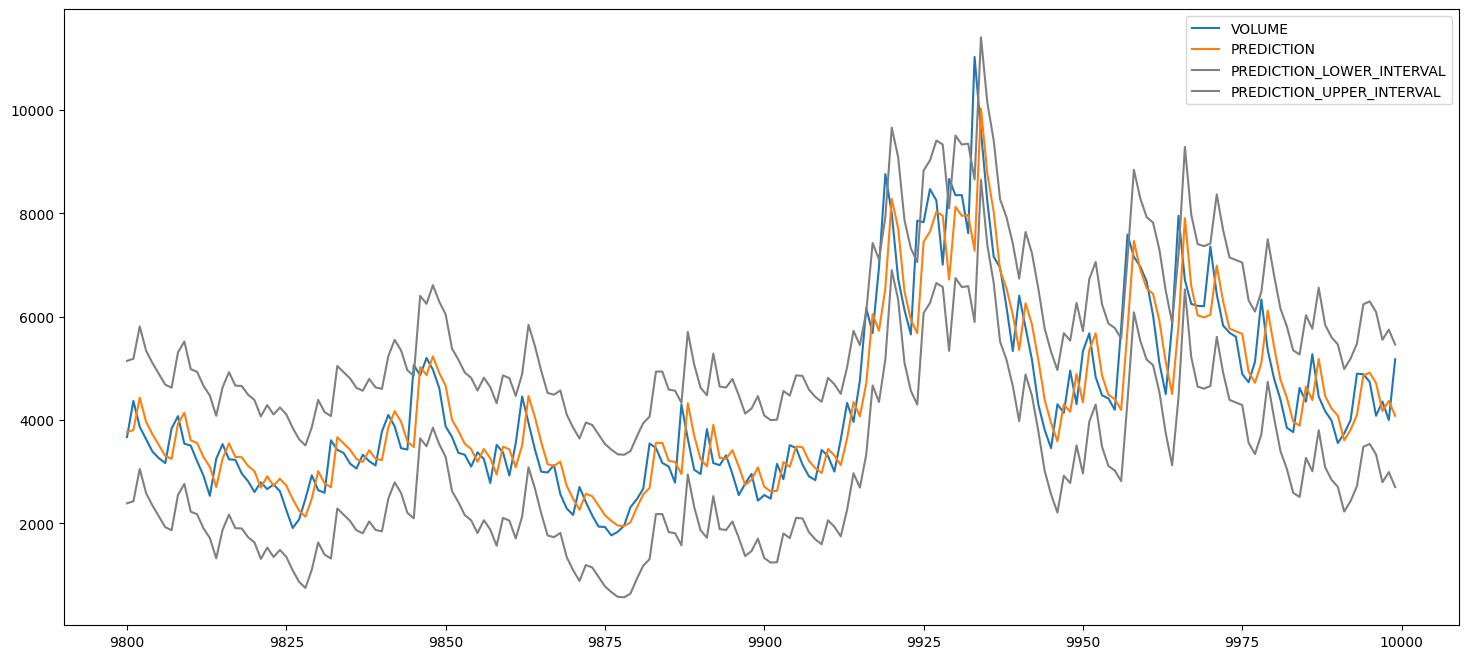

In [13]:
config_path = os.path.join('./min_config.yml')
config = yaml.load(open(config_path), Loader=yaml.Loader)
exp = build_experiment(config)

exp.get_data()
exp.prepare_data()
exp.init_fit()
exp.predict(x = exp.x_test)

pi_df = exp.prediction_intervals_onestep()

fig, ax = plt.subplots(figsize=(18, 8))
exp.df['VOLUME'].iloc[-200:].plot()
exp.prediction_reverse_processed['VOLUME_PREDICTION'].iloc[-200:].plot()
pi_df['VOLUME_LOWER_BORDER'].iloc[-200:].plot(c='gray')
pi_df['VOLUME_UPPER_BORDER'].iloc[-200:].plot(c='gray')
ax.legend(["VOLUME", "PREDICTION", 'PREDICTION_LOWER_INTERVAL', 'PREDICTION_UPPER_INTERVAL']);

## 12. Example of overriding experiment pipeline classes

DS-Framework allows for full customization of the experiment pipeline.

In [23]:
from dsframework.impl.datas import EquitiesOneTickData

class CustomDatafeed(EquitiesOneTickData):

    def load(self, *args):
        data = otp.DataSource(db=self.db,
                              tick_type=self.tick_type)
        data = data.agg({
                         'VOLUME': otp.agg.sum(data['VOLUME']),
                         'TICK_COUNT': otp.agg.sum(data['TRADE_TICK_COUNT']),
                        }, bucket_interval=self.bucket)

        df = otp.run(data,
                     apply_times_daily=True,
                     start=self.start + otp.Minute(1),
                     # the minute bar for 9:30-9:31 has the timestamp of 9:31
                     end=self.end + otp.Minute(1),
                     # the minute bar for 3:59-4:00 has the timestamp of 4:00 but the end timestamp is not included
                     symbols=self.symbols,
                     timezone=self.timezone)

        df = df[df['VOLUME'] > 0].reset_index(drop=True).set_index('Time')
        
        return df
    
config_path = os.path.join('./demo_config.yml')
config = yaml.load(open(config_path), Loader=yaml.Loader)
exp = build_experiment(config)
    
exp.datafeeds = [CustomDatafeed(db='NYSE_TAQ_BARS',
                                tick_type='TRD_1M',
                                symbols=['MA'],
                                start=[2022, 2, 1, 9, 30],
                                end=[2022, 4, 1, 16, 0])
                ]

## 13. Complex tuning: Features + Preprocessing + Models + Hyper-parameters with different time ranges and instruments

Any complex research can be carried out to select the best experiment parameters. This example examines the impact of adding extra features (in addition to lag values) as well as the use of "intraday_averaging" preprocessing on the perfomance of the ML models. To obtain a more reliable result, the calculation of metrics on various trading instruments and various time periods is used. In addition, the test sample is divided into several parts in order to evaluate not only the estimated metrics, but also their variance.

In [24]:
config_path = os.path.join('./demo_config.yml')
config = yaml.load(open(config_path), Loader=yaml.Loader)

config['datafeeds'][0] = {
    'class': 'dsframework.impl.EquitiesOneTickData',
    'use': True,
    'db': 'NYSE_TAQ_BARS',
    'tick_type': 'TRD_1M',
    'symbols': [ 'V' ],
    'start': [2022, 2, 1, 9, 30],
    'end': [2022, 4, 1, 16, 0],
    'bucket': 600
}

config['features'].append({
                              'class': 'dsframework.impl.AddLags',
                              'use': True,
                              'columns': ['TICK_COUNT'],
                              'periods': [1],
                              'use_as_inputs': False
                         })

config['features'].append({
                              'class': 'dsframework.impl.SelectColumns',
                              'use': True,
                              'columns': []
                          })

config['preprocessors'][0]['use'] = False
config['preprocessors'][1]['features_columns'] = ['VOLUME_lag_1', 'VOLUME_lag_2', 'VOLUME_lag_3', 'VOLUME_lag_4', 
                                                  'VOLUME_lag_38', 'VOLUME_lag_39', 'VOLUME_lag_40', 'VOLUME_lag_41']

periods = [([2018, 2, 1, 9, 30],[2020, 9, 1, 16, 0]), 
          ([2019, 2, 1, 9, 30],[2021, 9, 1, 16, 0]), 
          ([2020, 2, 3, 9, 30],[2022, 9, 3, 16, 0])]

symbols = ['V', 'MA', 'PYPL']

features_list = [[], ['feature_hhmm'], ['TICK_COUNT_lag_1']]

is_preprocessing_enabled = [True, False]

models = ['XGBRegressor']

def split_test_sample(data, n=10):
    step = round(len(data)/n+0.5)
    start = data.index[0]
    test_dfs = []
    for i in range(1, n+1):
        end = start + step
        test_dfs.append(data.loc[start:end-1])
        start = end
    return test_dfs

res = []
for period in periods:
    config['datafeeds'][0]['start'] = period[0]
    config['datafeeds'][0]['end'] = period[1]
    for symbol in symbols:
        config['datafeeds'][0]['symbols'] = symbol
        exp = build_experiment(config)        
        exp.datafeeds = [CustomDatafeed(db=exp.datafeeds[0].db,
                                        tick_type=exp.datafeeds[0].tick_type,
                                        symbols=exp.datafeeds[0].symbols,
                                        start=exp.datafeeds[0].start,
                                        end=exp.datafeeds[0].end)
                        ]
        df = exp.get_data()
        df['feature_hhmm'] = (pd.to_datetime(df['Time']).dt.strftime('%H%M')).astype(int)
        for features in features_list:
            config['features'][2]['columns'] = features
            for intraday_averaging in is_preprocessing_enabled:
                config['preprocessors'][1]['use'] = intraday_averaging
                for model in models:
                    config['training']['use'] = model
                    exp = build_experiment(config)
                    exp.prepare_data(df=df)
                    exp.init_fit(local_mode=True)

                    test_dfs = split_test_sample(exp.x_test, 10)

                    metrics = []
                    for test_df in test_dfs:
                        prediction = exp.predict(x = test_df)
                        metrics.append(exp.calc_metrics(y=exp.y_unprocessed.loc[test_df.index],
                                                        prediction = prediction))
                    metrics_df = pd.DataFrame(metrics)

                    iter_res = {'period': str(period), 
                                'symbol': symbol, 
                                'extra_features': str(features), 
                                'intraday_averaging': str(intraday_averaging), 
                                'model': model, 
                                'mean_MAPE': metrics_df.mean()[0], 
                                'std_MAPE': metrics_df.std()[0]}
                    print(exp.x_train.head(3))
                    print(iter_res)
                    res.append(iter_res)
res_df = pd.DataFrame(res)

2022-10-18 21:47:25,355	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:47:25,358	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.88gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:47:25,414	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
822    -147604.10    -129280.10     -153311.3     -135265.7      -88321.05      -76094.55      -57144.35       69926.05
823    -125601.45    -147604.10     -129280.1     -153311.3     -105568.25      -88321.05      -76094.55      -57144.35
824    -116878.40    -125601.45     -147604.1     -129280.1      -66921.40     -105568.25      -88321.05      -76094.55
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'V', 'extra_features': '[]', 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.2940584804608201, 'std_MAPE': 0.021738956205067234}


2022-10-18 21:47:48,655	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:47:48,657	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.88gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:47:48,745	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
42      594341.0      424106.0      783494.0      860071.0       208521.0       205956.0       311366.0       423897.0
43      533117.0      594341.0      424106.0      783494.0       195585.0       208521.0       205956.0       311366.0
44      448635.0      533117.0      594341.0      424106.0       240702.0       195585.0       208521.0       205956.0
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'V', 'extra_features': '[]', 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.3086811371134438, 'std_MAPE': 0.0350566793047645}


2022-10-18 21:48:15,187	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:48:15,190	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.88gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:48:15,255	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
822    -147604.10    -129280.10     -153311.3     -135265.7      -88321.05      -76094.55      -57144.35       69926.05          1011
823    -125601.45    -147604.10     -129280.1     -153311.3     -105568.25      -88321.05      -76094.55      -57144.35          1021
824    -116878.40    -125601.45     -147604.1     -129280.1      -66921.40     -105568.25      -88321.05      -76094.55          1031
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'V', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.2927114134132336, 'std_MAPE': 0.021283471268082138}


2022-10-18 21:48:40,359	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:48:40,362	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.88gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:48:40,418	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
42      594341.0      424106.0      783494.0      860071.0       208521.0       205956.0       311366.0       423897.0          1011
43      533117.0      594341.0      424106.0      783494.0       195585.0       208521.0       205956.0       311366.0          1021
44      448635.0      533117.0      594341.0      424106.0       240702.0       195585.0       208521.0       205956.0          1031
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'V', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.27705624205835094, 'std_MAPE': 0.028014593935613872}


2022-10-18 21:49:07,891	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:49:07,894	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:49:07,953	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
822    -147604.10    -129280.10     -153311.3     -135265.7      -88321.05      -76094.55      -57144.35       69926.05             725.0
823    -125601.45    -147604.10     -129280.1     -153311.3     -105568.25      -88321.05      -76094.55      -57144.35             782.0
824    -116878.40    -125601.45     -147604.1     -129280.1      -66921.40     -105568.25      -88321.05      -76094.55             733.0
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'V', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.2911234156669316, 'std_MAPE': 0.021531837590113775}


2022-10-18 21:49:31,975	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:49:31,977	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.88gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:49:32,046	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
42      594341.0      424106.0      783494.0      860071.0       208521.0       205956.0       311366.0       423897.0            3798.0
43      533117.0      594341.0      424106.0      783494.0       195585.0       208521.0       205956.0       311366.0            3169.0
44      448635.0      533117.0      594341.0      424106.0       240702.0       195585.0       208521.0       205956.0            2441.0
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'V', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.2946214785946577, 'std_MAPE': 0.03009164971422512}


2022-10-18 21:50:16,456	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:50:16,459	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.88gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:50:16,547	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
822      -17962.2      -72980.7      -83242.6     -138275.9       18568.40        32961.5       -8228.45       50004.00
823       19421.7      -17962.2      -72980.7      -83242.6      -30491.90        18568.4       32961.50       -8228.45
824      -47691.4       19421.7      -17962.2      -72980.7      -16676.15       -30491.9       18568.40       32961.50
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'MA', 'extra_features': '[]', 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.34107635981571327, 'std_MAPE': 0.04361834933715992}


2022-10-18 21:50:42,657	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:50:42,659	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:50:42,743	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
42      239330.0      269578.0      341044.0      381459.0       171735.0       215873.0       326588.0       348601.0
43      166634.0      239330.0      269578.0      341044.0       175754.0       171735.0       215873.0       326588.0
44      185043.0      166634.0      239330.0      269578.0       256843.0       175754.0       171735.0       215873.0
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'MA', 'extra_features': '[]', 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.3562290901815256, 'std_MAPE': 0.05796634187174208}


2022-10-18 21:51:09,256	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:51:09,259	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:51:09,344	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
822      -17962.2      -72980.7      -83242.6     -138275.9       18568.40        32961.5       -8228.45       50004.00          1011
823       19421.7      -17962.2      -72980.7      -83242.6      -30491.90        18568.4       32961.50       -8228.45          1021
824      -47691.4       19421.7      -17962.2      -72980.7      -16676.15       -30491.9       18568.40       32961.50          1031
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'MA', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.34555113623224054, 'std_MAPE': 0.04722729900010662}


2022-10-18 21:51:34,761	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:51:34,764	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:51:34,843	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
42      239330.0      269578.0      341044.0      381459.0       171735.0       215873.0       326588.0       348601.0          1011
43      166634.0      239330.0      269578.0      341044.0       175754.0       171735.0       215873.0       326588.0          1021
44      185043.0      166634.0      239330.0      269578.0       256843.0       175754.0       171735.0       215873.0          1031
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'MA', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.3238076171919841, 'std_MAPE': 0.055542189592928025}


2022-10-18 21:52:01,956	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:52:01,959	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.88gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:52:02,047	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
822      -17962.2      -72980.7      -83242.6     -138275.9       18568.40        32961.5       -8228.45       50004.00             761.0
823       19421.7      -17962.2      -72980.7      -83242.6      -30491.90        18568.4       32961.50       -8228.45            1205.0
824      -47691.4       19421.7      -17962.2      -72980.7      -16676.15       -30491.9       18568.40       32961.50             585.0
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'MA', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.33764291750011793, 'std_MAPE': 0.040348231406402195}


2022-10-18 21:52:29,269	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:52:29,272	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:52:29,354	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
42      239330.0      269578.0      341044.0      381459.0       171735.0       215873.0       326588.0       348601.0            1349.0
43      166634.0      239330.0      269578.0      341044.0       175754.0       171735.0       215873.0       326588.0            1210.0
44      185043.0      166634.0      239330.0      269578.0       256843.0       175754.0       171735.0       215873.0             968.0
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'MA', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.34080879421007315, 'std_MAPE': 0.049387598784492226}


2022-10-18 21:53:05,457	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:53:05,460	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:53:05,546	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
822    -111175.75    -175055.40    -263730.25     -52793.20     -174954.95     -189949.40     -177960.90      -354185.7
823     -30667.65    -111175.75    -175055.40    -263730.25     -123981.75     -174954.95     -189949.40      -177960.9
824    -143819.50     -30667.65    -111175.75    -175055.40     -143787.45     -123981.75     -174954.95      -189949.4
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'PYPL', 'extra_features': '[]', 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.31446137985027095, 'std_MAPE': 0.0231925432135372}


2022-10-18 21:53:27,256	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:53:27,258	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:53:27,351	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
42      585365.0      643815.0     1109644.0     1722660.0      1256943.0      1756981.0      2397478.0      4378279.0
43     1008918.0      585365.0      643815.0     1109644.0       979434.0      1256943.0      1756981.0      2397478.0
44      671443.0     1008918.0      585365.0      643815.0      1174646.0       979434.0      1256943.0      1756981.0
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'PYPL', 'extra_features': '[]', 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.3186407718879244, 'std_MAPE': 0.028351112061957933}


2022-10-18 21:53:48,065	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:53:48,067	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:53:48,146	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
822    -111175.75    -175055.40    -263730.25     -52793.20     -174954.95     -189949.40     -177960.90      -354185.7          1011
823     -30667.65    -111175.75    -175055.40    -263730.25     -123981.75     -174954.95     -189949.40      -177960.9          1021
824    -143819.50     -30667.65    -111175.75    -175055.40     -143787.45     -123981.75     -174954.95      -189949.4          1031
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'PYPL', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.31215446084452403, 'std_MAPE': 0.022981288846470528}


2022-10-18 21:54:12,771	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:54:12,774	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:54:12,851	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
42      585365.0      643815.0     1109644.0     1722660.0      1256943.0      1756981.0      2397478.0      4378279.0          1011
43     1008918.0      585365.0      643815.0     1109644.0       979434.0      1256943.0      1756981.0      2397478.0          1021
44      671443.0     1008918.0      585365.0      643815.0      1174646.0       979434.0      1256943.0      1756981.0          1031
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'PYPL', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.3025571070175587, 'std_MAPE': 0.03291249833853717}


2022-10-18 21:54:38,156	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:54:38,159	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:54:38,244	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
822    -111175.75    -175055.40    -263730.25     -52793.20     -174954.95     -189949.40     -177960.90      -354185.7            1255.0
823     -30667.65    -111175.75    -175055.40    -263730.25     -123981.75     -174954.95     -189949.40      -177960.9            1430.0
824    -143819.50     -30667.65    -111175.75    -175055.40     -143787.45     -123981.75     -174954.95      -189949.4             938.0
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'PYPL', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.31313835127732925, 'std_MAPE': 0.02482371753535868}


2022-10-18 21:55:00,569	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:55:00,571	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:55:00,651	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
42      585365.0      643815.0     1109644.0     1722660.0      1256943.0      1756981.0      2397478.0      4378279.0            3253.0
43     1008918.0      585365.0      643815.0     1109644.0       979434.0      1256943.0      1756981.0      2397478.0            5211.0
44      671443.0     1008918.0      585365.0      643815.0      1174646.0       979434.0      1256943.0      1756981.0            3670.0
{'period': '([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])', 'symbol': 'PYPL', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.297197193681094, 'std_MAPE': 0.02373961937841288}


2022-10-18 21:55:32,357	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:55:32,360	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:55:32,447	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
822      98593.95     -21114.60       9777.45     171835.55        1385.15      -22678.80      -20147.45      -45150.80
823      20851.30      98593.95     -21114.60       9777.45      -43308.70        1385.15      -22678.80      -20147.45
824     -36825.80      20851.30      98593.95     -21114.60      -36173.90      -43308.70        1385.15      -22678.80
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'V', 'extra_features': '[]', 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.3262892488813627, 'std_MAPE': 0.014335334819864713}


2022-10-18 21:55:58,456	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:55:58,459	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:55:58,544	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
42      173032.0      216915.0      277912.0      889511.0       348081.0       454599.0       468519.0       564125.0
43      213820.0      173032.0      216915.0      277912.0       400376.0       348081.0       454599.0       468519.0
44      130315.0      213820.0      173032.0      216915.0       248388.0       400376.0       348081.0       454599.0
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'V', 'extra_features': '[]', 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.38837546864766104, 'std_MAPE': 0.03512049446566363}


2022-10-18 21:56:25,156	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:56:25,158	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:56:25,246	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
822      98593.95     -21114.60       9777.45     171835.55        1385.15      -22678.80      -20147.45      -45150.80          1011
823      20851.30      98593.95     -21114.60       9777.45      -43308.70        1385.15      -22678.80      -20147.45          1021
824     -36825.80      20851.30      98593.95     -21114.60      -36173.90      -43308.70        1385.15      -22678.80          1031
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'V', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.32509284185217346, 'std_MAPE': 0.012272909947466666}


2022-10-18 21:56:52,556	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:56:52,560	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:56:52,657	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
42      173032.0      216915.0      277912.0      889511.0       348081.0       454599.0       468519.0       564125.0          1011
43      213820.0      173032.0      216915.0      277912.0       400376.0       348081.0       454599.0       468519.0          1021
44      130315.0      213820.0      173032.0      216915.0       248388.0       400376.0       348081.0       454599.0          1031
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'V', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.38103463135362714, 'std_MAPE': 0.0476098505801167}


2022-10-18 21:57:15,151	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:57:15,153	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:57:15,245	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
822      98593.95     -21114.60       9777.45     171835.55        1385.15      -22678.80      -20147.45      -45150.80             905.0
823      20851.30      98593.95     -21114.60       9777.45      -43308.70        1385.15      -22678.80      -20147.45             960.0
824     -36825.80      20851.30      98593.95     -21114.60      -36173.90      -43308.70        1385.15      -22678.80             871.0
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'V', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.3213933698327419, 'std_MAPE': 0.012152758321872102}


2022-10-18 21:57:42,472	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:57:42,476	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.88gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:57:42,544	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
42      173032.0      216915.0      277912.0      889511.0       348081.0       454599.0       468519.0       564125.0            1185.0
43      213820.0      173032.0      216915.0      277912.0       400376.0       348081.0       454599.0       468519.0            1408.0
44      130315.0      213820.0      173032.0      216915.0       248388.0       400376.0       348081.0       454599.0             871.0
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'V', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.37692873606459765, 'std_MAPE': 0.033896171035171306}


2022-10-18 21:58:24,057	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:58:24,060	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:58:24,143	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
822     -32747.55     -48886.45     -35891.10      -3659.60       -5062.40      -16919.50       -2912.35      -11573.90
823      13417.00     -32747.55     -48886.45     -35891.10      -14122.55       -5062.40      -16919.50       -2912.35
824     -23246.10      13417.00     -32747.55     -48886.45       -2830.60      -14122.55       -5062.40      -16919.50
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'MA', 'extra_features': '[]', 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.3732140768190887, 'std_MAPE': 0.03568509180771773}


2022-10-18 21:58:49,563	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:58:49,566	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.88gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:58:49,644	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
42       72255.0       59864.0       95659.0      380714.0       190243.0       262757.0       174396.0       328608.0
43      103699.0       72255.0       59864.0       95659.0       112845.0       190243.0       262757.0       174396.0
44       68465.0      103699.0       72255.0       59864.0       150970.0       112845.0       190243.0       262757.0
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'MA', 'extra_features': '[]', 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.4050208290241958, 'std_MAPE': 0.04558786951229712}


2022-10-18 21:59:06,952	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:59:06,955	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:59:07,044	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
822     -32747.55     -48886.45     -35891.10      -3659.60       -5062.40      -16919.50       -2912.35      -11573.90          1011
823      13417.00     -32747.55     -48886.45     -35891.10      -14122.55       -5062.40      -16919.50       -2912.35          1021
824     -23246.10      13417.00     -32747.55     -48886.45       -2830.60      -14122.55       -5062.40      -16919.50          1031
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'MA', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.3716913142442488, 'std_MAPE': 0.035847493233916075}


2022-10-18 21:59:31,156	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:59:31,159	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.88gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:59:31,247	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
42       72255.0       59864.0       95659.0      380714.0       190243.0       262757.0       174396.0       328608.0          1011
43      103699.0       72255.0       59864.0       95659.0       112845.0       190243.0       262757.0       174396.0          1021
44       68465.0      103699.0       72255.0       59864.0       150970.0       112845.0       190243.0       262757.0          1031
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'MA', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.40401531435270055, 'std_MAPE': 0.05012671250130984}


2022-10-18 21:59:51,850	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 21:59:51,854	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 21:59:51,957	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
822     -32747.55     -48886.45     -35891.10      -3659.60       -5062.40      -16919.50       -2912.35      -11573.90             264.0
823      13417.00     -32747.55     -48886.45     -35891.10      -14122.55       -5062.40      -16919.50       -2912.35             580.0
824     -23246.10      13417.00     -32747.55     -48886.45       -2830.60      -14122.55       -5062.40      -16919.50             207.0
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'MA', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.36779420031341625, 'std_MAPE': 0.033884239482522366}


2022-10-18 22:00:20,157	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:00:20,160	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:00:20,247	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
42       72255.0       59864.0       95659.0      380714.0       190243.0       262757.0       174396.0       328608.0             419.0
43      103699.0       72255.0       59864.0       95659.0       112845.0       190243.0       262757.0       174396.0             747.0
44       68465.0      103699.0       72255.0       59864.0       150970.0       112845.0       190243.0       262757.0             402.0
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'MA', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.3874288749993193, 'std_MAPE': 0.0427997803091366}


2022-10-18 22:00:49,570	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:00:49,573	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:00:49,644	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
822     -28475.65     -84033.00    -142164.25     -71935.15       -4533.75       18939.60       16431.90       92358.45
823     -32932.25     -28475.65     -84033.00    -142164.25       -9377.30       -4533.75       18939.60       16431.90
824     -44581.45     -32932.25     -28475.65     -84033.00       23023.20       -9377.30       -4533.75       18939.60
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'PYPL', 'extra_features': '[]', 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.3299389185907667, 'std_MAPE': 0.04298026025878557}


2022-10-18 22:01:14,156	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:01:14,159	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:01:14,247	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
42      114614.0      105626.0      224318.0      640963.0       373388.0       365200.0       601882.0       675144.0
43      109585.0      114614.0      105626.0      224318.0       226699.0       373388.0       365200.0       601882.0
44      138657.0      109585.0      114614.0      105626.0       145520.0       226699.0       373388.0       365200.0
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'PYPL', 'extra_features': '[]', 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.4322350507829462, 'std_MAPE': 0.11751488752501947}


2022-10-18 22:01:35,853	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:01:35,856	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:01:35,945	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
822     -28475.65     -84033.00    -142164.25     -71935.15       -4533.75       18939.60       16431.90       92358.45          1011
823     -32932.25     -28475.65     -84033.00    -142164.25       -9377.30       -4533.75       18939.60       16431.90          1021
824     -44581.45     -32932.25     -28475.65     -84033.00       23023.20       -9377.30       -4533.75       18939.60          1031
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'PYPL', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.32687893529894724, 'std_MAPE': 0.04277730618964792}


2022-10-18 22:02:02,558	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:02:02,561	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:02:02,647	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
42      114614.0      105626.0      224318.0      640963.0       373388.0       365200.0       601882.0       675144.0          1011
43      109585.0      114614.0      105626.0      224318.0       226699.0       373388.0       365200.0       601882.0          1021
44      138657.0      109585.0      114614.0      105626.0       145520.0       226699.0       373388.0       365200.0          1031
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'PYPL', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.4248114096850334, 'std_MAPE': 0.11622384312709817}


2022-10-18 22:02:24,856	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:02:24,860	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:02:24,945	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
822     -28475.65     -84033.00    -142164.25     -71935.15       -4533.75       18939.60       16431.90       92358.45             748.0
823     -32932.25     -28475.65     -84033.00    -142164.25       -9377.30       -4533.75       18939.60       16431.90             808.0
824     -44581.45     -32932.25     -28475.65     -84033.00       23023.20       -9377.30       -4533.75       18939.60             806.0
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'PYPL', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.33041290927845823, 'std_MAPE': 0.043962625796396836}


2022-10-18 22:02:50,067	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:02:50,070	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:02:50,147	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
42      114614.0      105626.0      224318.0      640963.0       373388.0       365200.0       601882.0       675144.0             719.0
43      109585.0      114614.0      105626.0      224318.0       226699.0       373388.0       365200.0       601882.0             716.0
44      138657.0      109585.0      114614.0      105626.0       145520.0       226699.0       373388.0       365200.0             811.0
{'period': '([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])', 'symbol': 'PYPL', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.47614912884731775, 'std_MAPE': 0.13084987946158133}


2022-10-18 22:03:28,261	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:03:28,265	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:03:28,322	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
822      48407.90      -4731.85     -83327.55     285714.60      186379.85      346201.70       -5784.90       11252.75
823      57862.85      48407.90      -4731.85     -83327.55       64643.95      186379.85      346201.70       -5784.90
824     -12072.90      57862.85      48407.90      -4731.85      -10942.55       64643.95      186379.85      346201.70
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'V', 'extra_features': '[]', 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.31854215830916593, 'std_MAPE': 0.05651229401670128}


2022-10-18 22:03:53,763	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:03:53,766	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:03:53,844	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
42      167862.0      280480.0      429689.0      518748.0       162911.0       195748.0       259996.0       195930.0
43      296155.0      167862.0      280480.0      429689.0       145137.0       162911.0       195748.0       259996.0
44      150611.0      296155.0      167862.0      280480.0       144311.0       145137.0       162911.0       195748.0
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'V', 'extra_features': '[]', 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.3818063271208582, 'std_MAPE': 0.08467641343039559}


2022-10-18 22:04:11,068	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:04:11,071	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:04:11,126	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
822      48407.90      -4731.85     -83327.55     285714.60      186379.85      346201.70       -5784.90       11252.75          1011
823      57862.85      48407.90      -4731.85     -83327.55       64643.95      186379.85      346201.70       -5784.90          1021
824     -12072.90      57862.85      48407.90      -4731.85      -10942.55       64643.95      186379.85      346201.70          1031
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'V', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.31816074638228414, 'std_MAPE': 0.056826216019200536}


2022-10-18 22:04:37,771	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:04:37,774	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.88gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:04:37,847	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
42      167862.0      280480.0      429689.0      518748.0       162911.0       195748.0       259996.0       195930.0          1011
43      296155.0      167862.0      280480.0      429689.0       145137.0       162911.0       195748.0       259996.0          1021
44      150611.0      296155.0      167862.0      280480.0       144311.0       145137.0       162911.0       195748.0          1031
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'V', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.3804779819260437, 'std_MAPE': 0.09594553993832021}


2022-10-18 22:05:00,287	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:05:00,293	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:05:00,375	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
822      48407.90      -4731.85     -83327.55     285714.60      186379.85      346201.70       -5784.90       11252.75            2426.0
823      57862.85      48407.90      -4731.85     -83327.55       64643.95      186379.85      346201.70       -5784.90            2169.0
824     -12072.90      57862.85      48407.90      -4731.85      -10942.55       64643.95      186379.85      346201.70            1594.0
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'V', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.3174170683426851, 'std_MAPE': 0.05734871254096459}


2022-10-18 22:05:26,279	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:05:26,283	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:05:26,355	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
42      167862.0      280480.0      429689.0      518748.0       162911.0       195748.0       259996.0       195930.0            1141.0
43      296155.0      167862.0      280480.0      429689.0       145137.0       162911.0       195748.0       259996.0            1550.0
44      150611.0      296155.0      167862.0      280480.0       144311.0       145137.0       162911.0       195748.0             944.0
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'V', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.37438901505798683, 'std_MAPE': 0.08592276514394336}


2022-10-18 22:06:01,466	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:06:01,469	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:06:01,547	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
822     104473.90      34330.85     -26237.70     212184.35       82019.45      201126.15      -20722.50      -38240.05
823      82511.50     104473.90      34330.85     -26237.70       32768.25       82019.45      201126.15      -20722.50
824      57447.65      82511.50     104473.90      34330.85      116895.50       32768.25       82019.45      201126.15
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'MA', 'extra_features': '[]', 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.3726587968254219, 'std_MAPE': 0.03244471517045658}


2022-10-18 22:06:25,767	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:06:25,770	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:06:26,832	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
42      106138.0      114570.0      167711.0      217874.0        74036.0        64248.0        77430.0        95207.0
43       77762.0      106138.0      114570.0      167711.0        59999.0        74036.0        64248.0        77430.0
44       64815.0       77762.0      106138.0      114570.0        42200.0        59999.0        74036.0        64248.0
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'MA', 'extra_features': '[]', 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.49300778418701635, 'std_MAPE': 0.09281766109984939}


2022-10-18 22:06:43,056	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:06:43,060	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:06:43,145	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
822     104473.90      34330.85     -26237.70     212184.35       82019.45      201126.15      -20722.50      -38240.05          1011
823      82511.50     104473.90      34330.85     -26237.70       32768.25       82019.45      201126.15      -20722.50          1021
824      57447.65      82511.50     104473.90      34330.85      116895.50       32768.25       82019.45      201126.15          1031
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'MA', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.37134696799166816, 'std_MAPE': 0.03290268120773}


2022-10-18 22:07:09,267	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:07:09,270	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:07:09,349	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
42      106138.0      114570.0      167711.0      217874.0        74036.0        64248.0        77430.0        95207.0          1011
43       77762.0      106138.0      114570.0      167711.0        59999.0        74036.0        64248.0        77430.0          1021
44       64815.0       77762.0      106138.0      114570.0        42200.0        59999.0        74036.0        64248.0          1031
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'MA', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.49590712147901267, 'std_MAPE': 0.11110945711653436}


2022-10-18 22:07:29,874	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:07:29,877	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:07:29,954	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
822     104473.90      34330.85     -26237.70     212184.35       82019.45      201126.15      -20722.50      -38240.05            1852.0
823      82511.50     104473.90      34330.85     -26237.70       32768.25       82019.45      201126.15      -20722.50            1625.0
824      57447.65      82511.50     104473.90      34330.85      116895.50       32768.25       82019.45      201126.15            1289.0
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'MA', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.3679397957956796, 'std_MAPE': 0.03417215783339725}


2022-10-18 22:07:55,260	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:07:55,263	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:07:56,326	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
42      106138.0      114570.0      167711.0      217874.0        74036.0        64248.0        77430.0        95207.0             557.0
43       77762.0      106138.0      114570.0      167711.0        59999.0        74036.0        64248.0        77430.0             544.0
44       64815.0       77762.0      106138.0      114570.0        42200.0        59999.0        74036.0        64248.0             441.0
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'MA', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.4821770880946793, 'std_MAPE': 0.10002823810496339}


2022-10-18 22:08:19,171	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:08:19,175	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:08:19,259	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
822     -57486.25    -107635.65     -45437.40     207125.30      170764.95      367335.10       -7751.45       31816.30
823        325.25     -57486.25    -107635.65     -45437.40      173817.85      170764.95      367335.10       -7751.45
824     -62377.40        325.25     -57486.25    -107635.65       87052.40      173817.85      170764.95      367335.10
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'PYPL', 'extra_features': '[]', 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.29373369152401463, 'std_MAPE': 0.045955016999753906}


2022-10-18 22:08:44,456	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:08:44,460	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:08:44,547	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41
42      217969.0      211389.0      350095.0      461574.0        98608.0       184869.0       144496.0       137373.0
43      105785.0      217969.0      211389.0      350095.0       133672.0        98608.0       184869.0       144496.0
44      107299.0      105785.0      217969.0      211389.0       225173.0       133672.0        98608.0       184869.0
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'PYPL', 'extra_features': '[]', 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.2952841853422479, 'std_MAPE': 0.026600704745929397}


2022-10-18 22:09:10,857	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:09:10,861	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:09:10,921	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
822     -57486.25    -107635.65     -45437.40     207125.30      170764.95      367335.10       -7751.45       31816.30          1011
823        325.25     -57486.25    -107635.65     -45437.40      173817.85      170764.95      367335.10       -7751.45          1021
824     -62377.40        325.25     -57486.25    -107635.65       87052.40      173817.85      170764.95      367335.10          1031
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'PYPL', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.2930089310770102, 'std_MAPE': 0.04660178252953409}


2022-10-18 22:09:37,364	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:09:37,368	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:09:37,444	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  feature_hhmm
42      217969.0      211389.0      350095.0      461574.0        98608.0       184869.0       144496.0       137373.0          1011
43      105785.0      217969.0      211389.0      350095.0       133672.0        98608.0       184869.0       144496.0          1021
44      107299.0      105785.0      217969.0      211389.0       225173.0       133672.0        98608.0       184869.0          1031
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'PYPL', 'extra_features': "['feature_hhmm']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.2545660959805853, 'std_MAPE': 0.02040074787428103}


2022-10-18 22:10:04,769	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:10:04,773	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:10:04,844	INFO worker.py:1518 -- Started a local Ray instance.


     VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
822     -57486.25    -107635.65     -45437.40     207125.30      170764.95      367335.10       -7751.45       31816.30            1313.0
823        325.25     -57486.25    -107635.65     -45437.40      173817.85      170764.95      367335.10       -7751.45            1477.0
824     -62377.40        325.25     -57486.25    -107635.65       87052.40      173817.85      170764.95      367335.10             771.0
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'PYPL', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'True', 'model': 'XGBRegressor', 'mean_MAPE': 0.29261440393987687, 'std_MAPE': 0.043645477540823714}


2022-10-18 22:10:31,371	WARNING utils.py:594 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2022-10-18 22:10:31,375	WARNING services.py:1882 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.87gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-18 22:10:31,444	INFO worker.py:1518 -- Started a local Ray instance.


    VOLUME_lag_1  VOLUME_lag_2  VOLUME_lag_3  VOLUME_lag_4  VOLUME_lag_38  VOLUME_lag_39  VOLUME_lag_40  VOLUME_lag_41  TICK_COUNT_lag_1
42      217969.0      211389.0      350095.0      461574.0        98608.0       184869.0       144496.0       137373.0            1122.0
43      105785.0      217969.0      211389.0      350095.0       133672.0        98608.0       184869.0       144496.0             710.0
44      107299.0      105785.0      217969.0      211389.0       225173.0       133672.0        98608.0       184869.0             669.0
{'period': '([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])', 'symbol': 'PYPL', 'extra_features': "['TICK_COUNT_lag_1']", 'intraday_averaging': 'False', 'model': 'XGBRegressor', 'mean_MAPE': 0.27019462625983315, 'std_MAPE': 0.020187292295233115}


In [25]:
# All results
res_df

,period,symbol,extra_features,intraday_averaging,model,mean_MAPE,std_MAPE
0,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",V,[],True,XGBRegressor,0.294058,0.021739
1,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",V,[],False,XGBRegressor,0.308681,0.035057
2,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",V,['feature_hhmm'],True,XGBRegressor,0.292711,0.021283
3,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",V,['feature_hhmm'],False,XGBRegressor,0.277056,0.028015
4,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",V,['TICK_COUNT_lag_1'],True,XGBRegressor,0.291123,0.021532
5,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",V,['TICK_COUNT_lag_1'],False,XGBRegressor,0.294621,0.030092
6,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",MA,[],True,XGBRegressor,0.341076,0.043618
7,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",MA,[],False,XGBRegressor,0.356229,0.057966
8,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",MA,['feature_hhmm'],True,XGBRegressor,0.345551,0.047227
9,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",MA,['feature_hhmm'],False,XGBRegressor,0.323808,0.055542


In [26]:
# Top-3 MAPE for each symbol-period
top3_res_df = res_df.sort_values(by=['symbol', 'period', 'mean_MAPE']).groupby(['symbol', 'period']).head(3)
top3_res_df

,period,symbol,extra_features,intraday_averaging,model,mean_MAPE,std_MAPE
9,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",MA,['feature_hhmm'],False,XGBRegressor,0.323808,0.055542
10,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",MA,['TICK_COUNT_lag_1'],True,XGBRegressor,0.337643,0.040348
11,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",MA,['TICK_COUNT_lag_1'],False,XGBRegressor,0.340809,0.049388
28,"([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])",MA,['TICK_COUNT_lag_1'],True,XGBRegressor,0.367794,0.033884
26,"([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])",MA,['feature_hhmm'],True,XGBRegressor,0.371691,0.035847
24,"([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0])",MA,[],True,XGBRegressor,0.373214,0.035685
46,"([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])",MA,['TICK_COUNT_lag_1'],True,XGBRegressor,0.367940,0.034172
44,"([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])",MA,['feature_hhmm'],True,XGBRegressor,0.371347,0.032903
42,"([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0])",MA,[],True,XGBRegressor,0.372659,0.032445
17,"([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0])",PYPL,['TICK_COUNT_lag_1'],False,XGBRegressor,0.297197,0.023740


In [27]:
# Number of hits in the top 3
ef_ia_cnt_df = top3_res_df.groupby(['extra_features','intraday_averaging'])[['model']].count()
ef_ia_cnt_df

model
extra_features       intraday_averaging       
['TICK_COUNT_lag_1'] False                   3
                     True                    8
['feature_hhmm']     False                   4
                     True                    7
[]                   True                    5

<AxesSubplot:title={'center':'Number of hits in the top 3'}, xlabel='extra_features,intraday_averaging'>

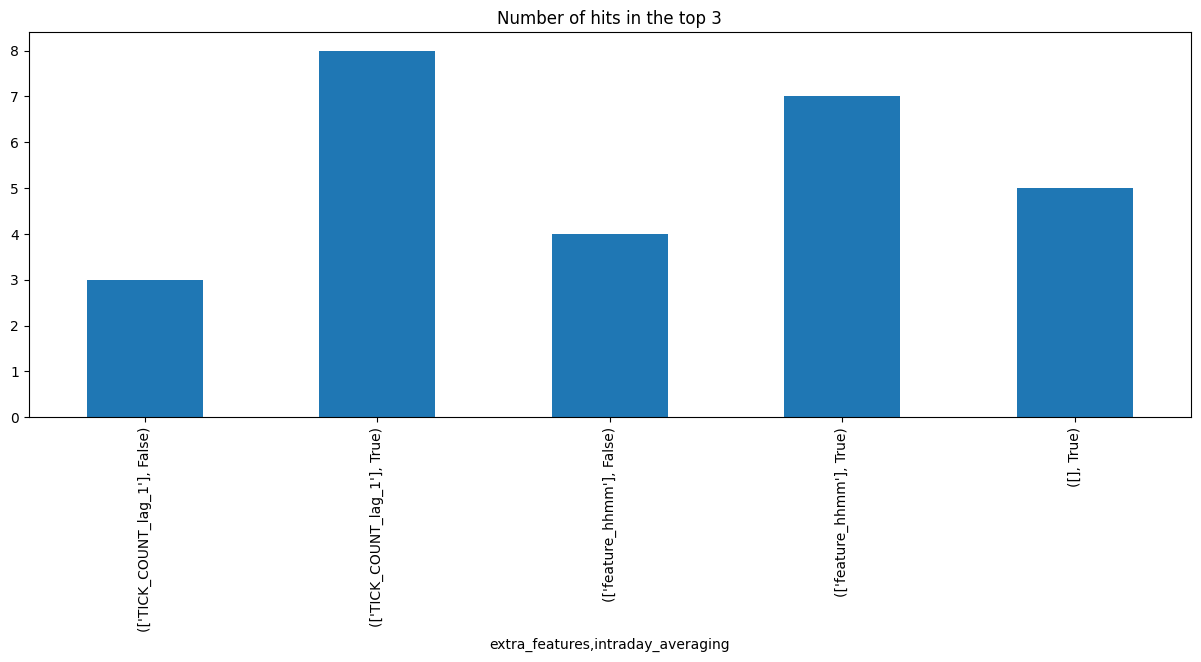

In [28]:
ef_ia_cnt_df.plot(kind='bar', figsize=[15, 5], legend=False, title='Number of hits in the top 3')

In [29]:
# Mean MAPE for each extra_features-intraday_averaging pair (overall)
ef_ia_mape_df = res_df.groupby(['extra_features','intraday_averaging'])[['mean_MAPE', 'std_MAPE']].mean()

# Mean MAPE for each type of extra_features: TICK_COUNT_lag_1/feature_hhmm/[] (overall)
ef_mape_df = res_df.groupby(['extra_features'])[['mean_MAPE', 'std_MAPE']].mean()

# Mean MAPE for each type of intraday_averaging: True/False (overall)
ia_mape_df = res_df.groupby(['intraday_averaging'])[['mean_MAPE', 'std_MAPE']].mean()

ef_ia_mape_df

mean_MAPE  std_MAPE
extra_features       intraday_averaging                     
['TICK_COUNT_lag_1'] False                0.366655  0.057434
                     True                 0.326608  0.034652
['feature_hhmm']     False                0.360470  0.061987
                     True                 0.328511  0.035413
[]                   False                0.375476  0.058188
                     True                 0.329330  0.035163

<AxesSubplot:title={'center':'Mean MAPE for each type of intraday_averaging (overall)'}, xlabel='intraday_averaging'>

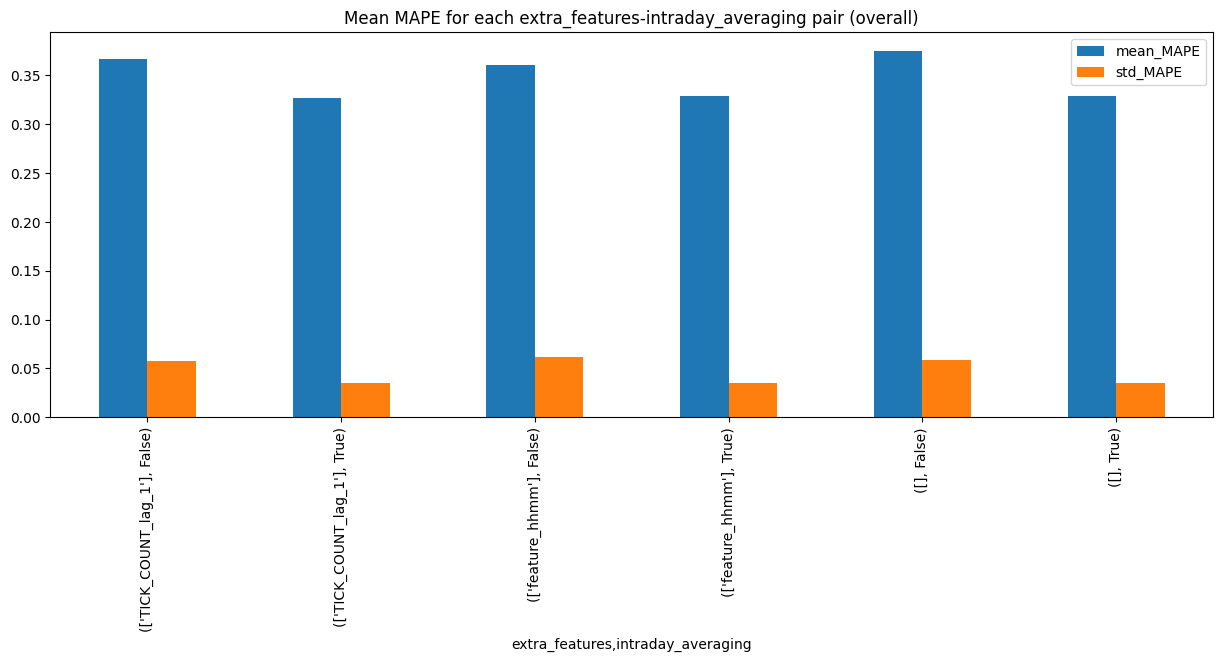

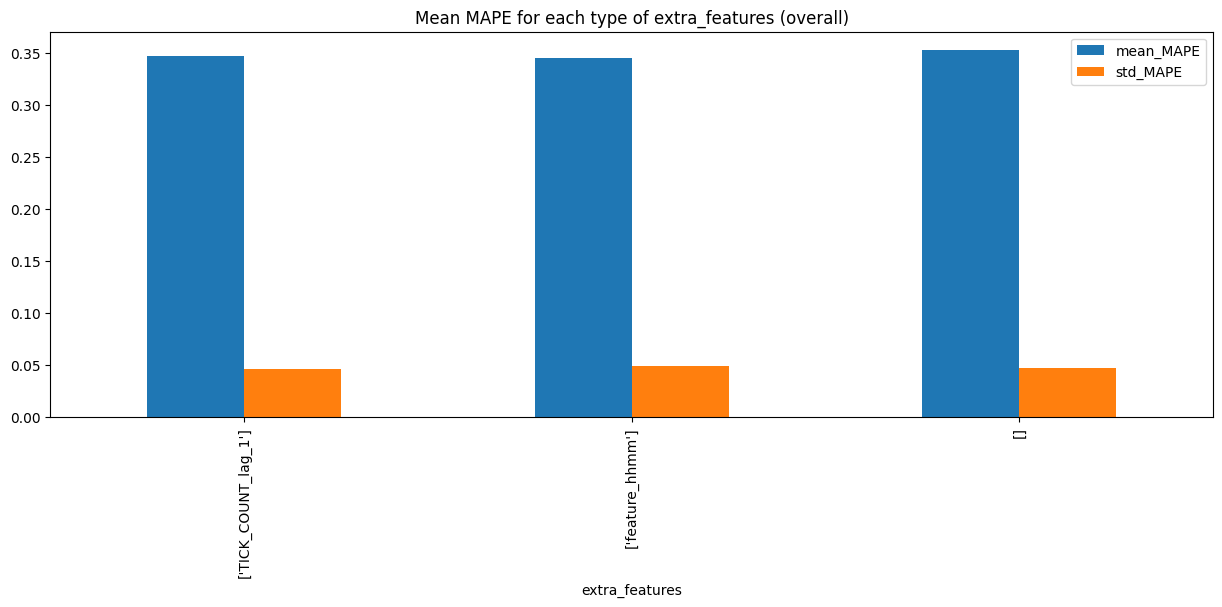

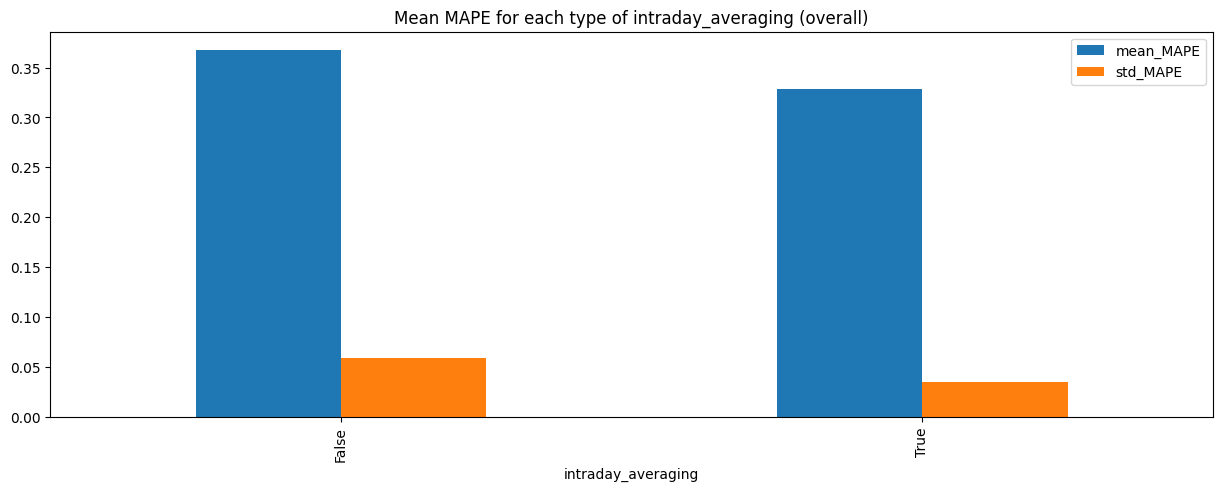

In [30]:
ef_ia_mape_df.plot(kind='bar', figsize=[15, 5], title='Mean MAPE for each extra_features-intraday_averaging pair (overall)')
ef_mape_df.plot(kind='bar', figsize=[15, 5], title='Mean MAPE for each type of extra_features (overall)')
ia_mape_df.plot(kind='bar', figsize=[15, 5], title='Mean MAPE for each type of intraday_averaging (overall)')

In [31]:
# Mean MAPE for each extra_features-intraday_averaging pair (by simbols)
sym_ef_ia_mape_df = res_df.groupby(['symbol', 'extra_features','intraday_averaging'])[['mean_MAPE', 'std_MAPE']].mean()
sym_ef_ia_mape_df

mean_MAPE  std_MAPE
symbol extra_features       intraday_averaging                     
MA     ['TICK_COUNT_lag_1'] False                0.403472  0.064072
                            True                 0.357792  0.036135
       ['feature_hhmm']     False                0.407910  0.072259
                            True                 0.362863  0.038659
       []                   False                0.418086  0.065457
                            True                 0.362316  0.037249
PYPL   ['TICK_COUNT_lag_1'] False                0.347847  0.058259
                            True                 0.312055  0.037477
       ['feature_hhmm']     False                0.327312  0.056512
                            True                 0.310681  0.037453
       []                   False                0.348720  0.057489
                            True                 0.312711  0.037376
V      ['TICK_COUNT_lag_1'] False                0.348646  0.049970
                            True                 0.309978  0.030344
       ['feature_hhmm']     False                0.346190  0.057190
                            True                 0.311988  0.030128
       []                   False                0.359621  0.051618
                            True                 0.312963  0.030862

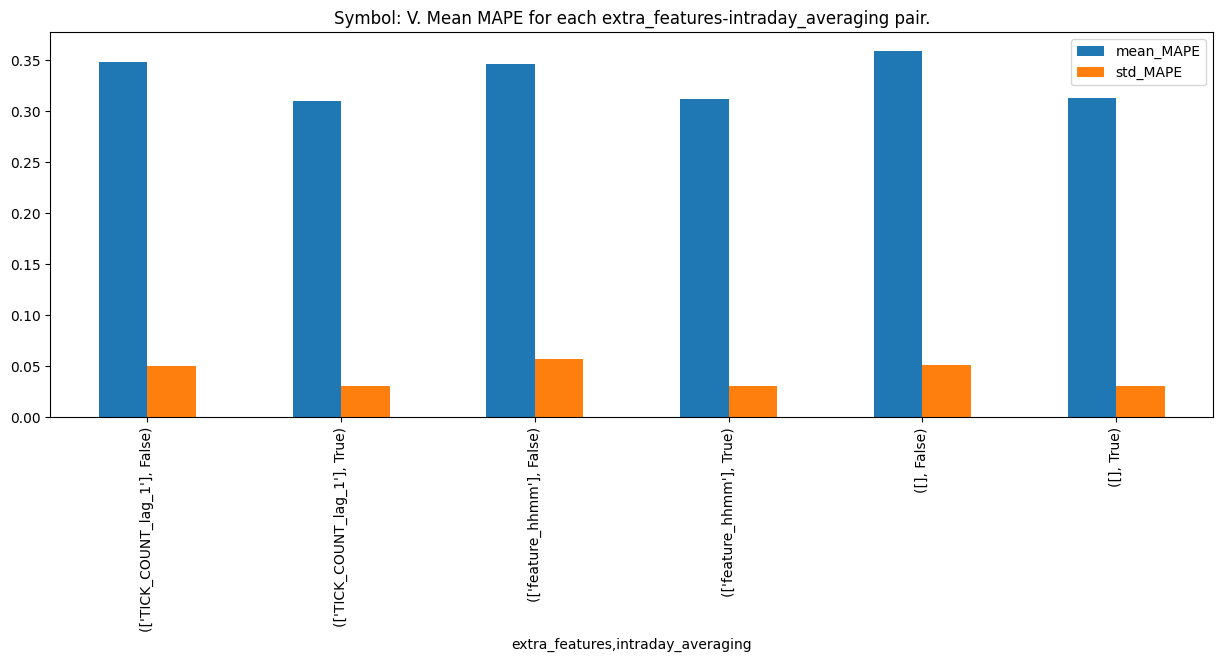

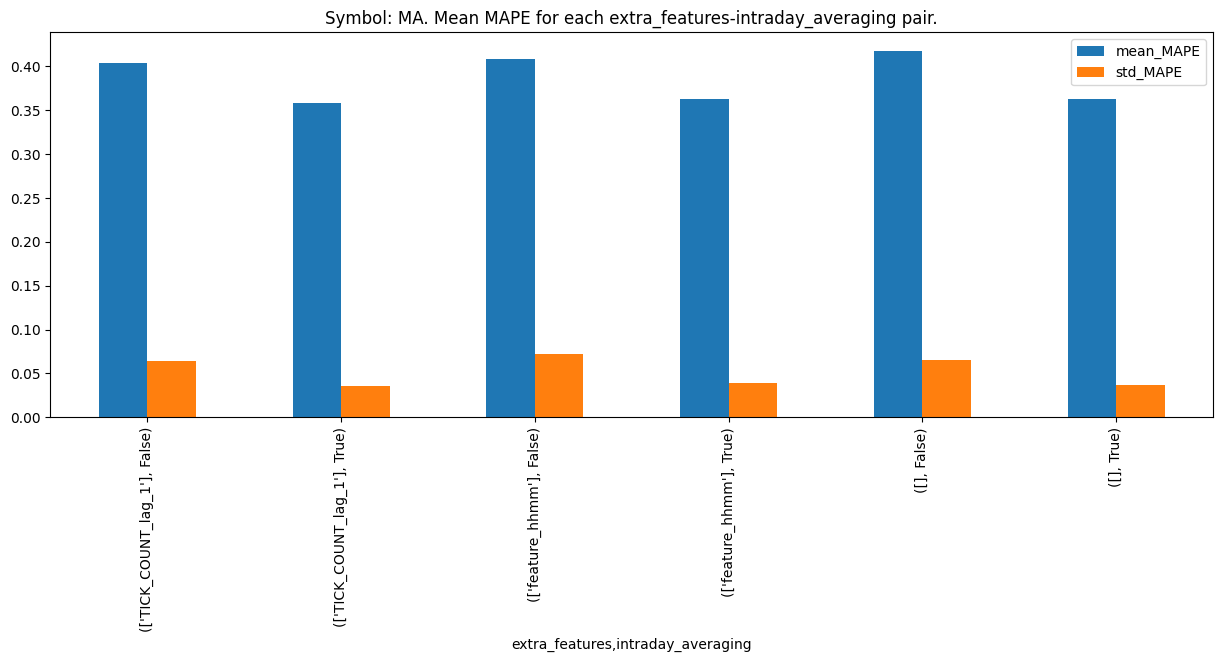

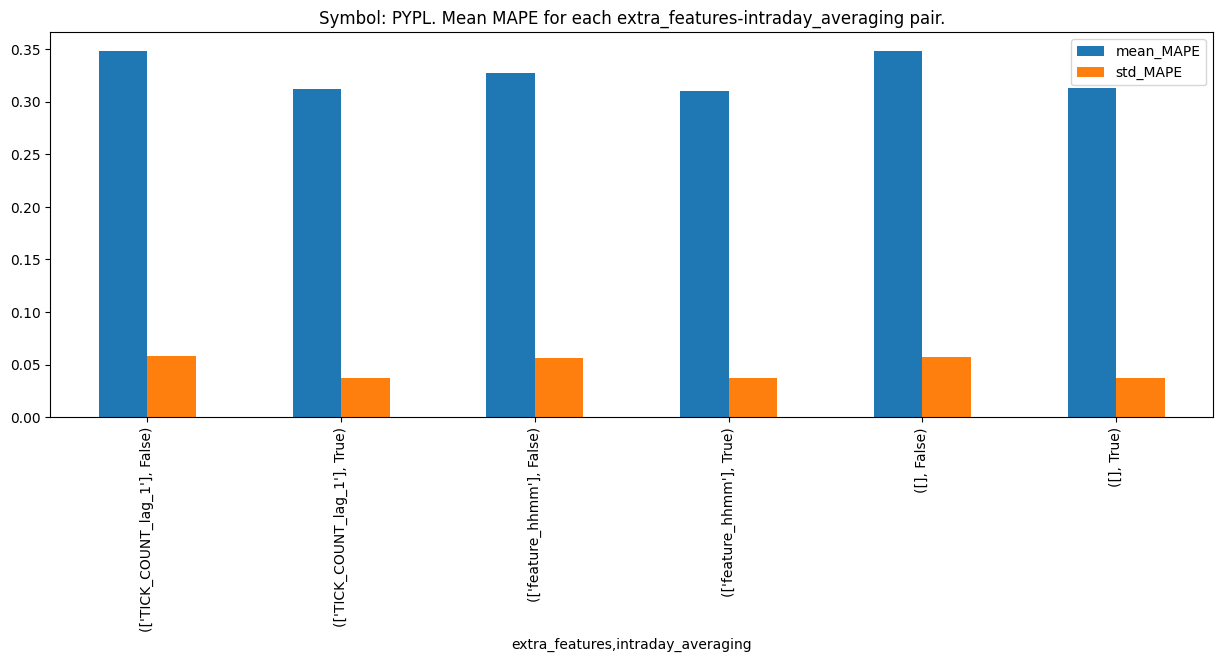

In [32]:
tdf = sym_ef_ia_mape_df.reset_index()
for symbol in symbols:
    pdf = tdf[tdf['symbol']==symbol]
    pdf = pdf.set_index(['extra_features', 'intraday_averaging'])
    pdf.plot(kind='bar', figsize=[15, 5], title=f'Symbol: {symbol}. Mean MAPE for each extra_features-intraday_averaging pair.')
    plt.show()

In [33]:
# Mean MAPE for each extra_features-intraday_averaging pair (by periods)
per_ef_ia_mape_df = res_df.groupby(['period', 'extra_features','intraday_averaging'])[['mean_MAPE', 'std_MAPE']].mean()
per_ef_ia_mape_df

mean_MAPE  std_MAPE
period                                     extra_features       intraday_averaging                     
([2018, 2, 1, 9, 30], [2020, 9, 1, 16, 0]) ['TICK_COUNT_lag_1'] False                0.310876  0.034406
                                                                True                 0.313968  0.028901
                                           ['feature_hhmm']     False                0.301140  0.038823
                                                                True                 0.316806  0.030497
                                           []                   False                0.327850  0.040458
                                                                True                 0.316532  0.029517
([2019, 2, 1, 9, 30], [2021, 9, 1, 16, 0]) ['TICK_COUNT_lag_1'] False                0.413502  0.069182
                                                                True                 0.339867  0.030000
                                           ['feature_hhmm']     False                0.403287  0.071320
                                                                True                 0.341221  0.030299
                                           []                   False                0.408544  0.066074
                                                                True                 0.343147  0.031000
([2020, 2, 3, 9, 30], [2022, 9, 3, 16, 0]) ['TICK_COUNT_lag_1'] False                0.375587  0.068713
                                                                True                 0.325990  0.045055
                                           ['feature_hhmm']     False                0.376984  0.075819
                                                                True                 0.327506  0.045444
                                           []                   False                0.390033  0.068032
                                                                True                 0.328312  0.044971

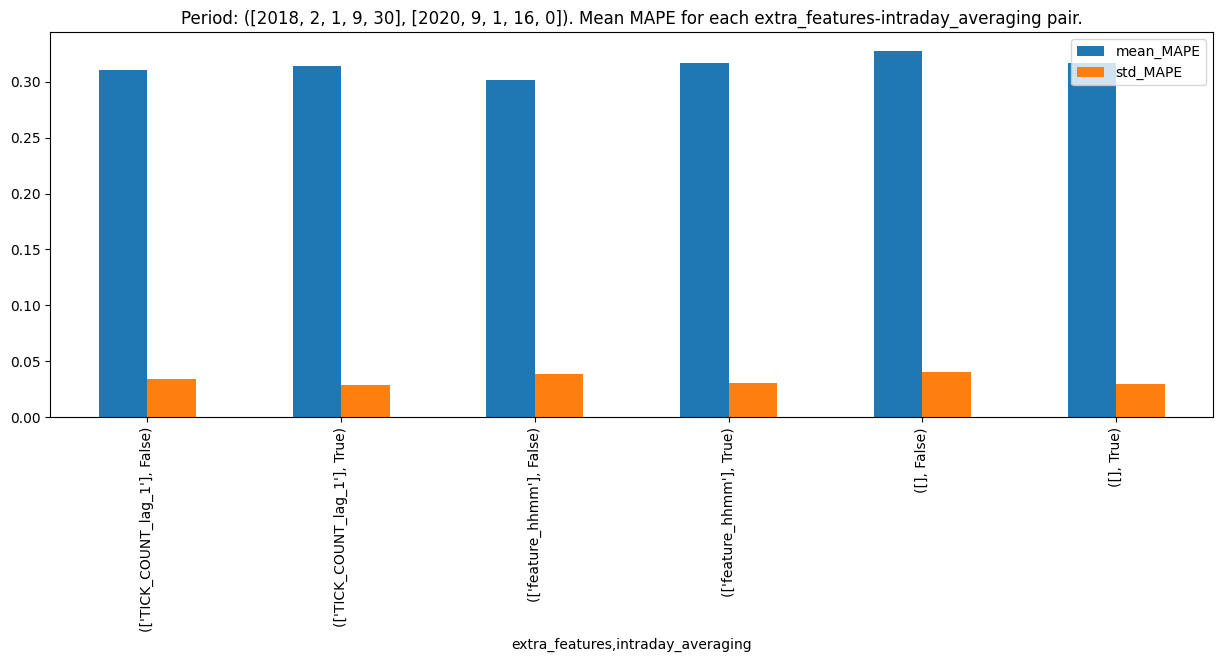

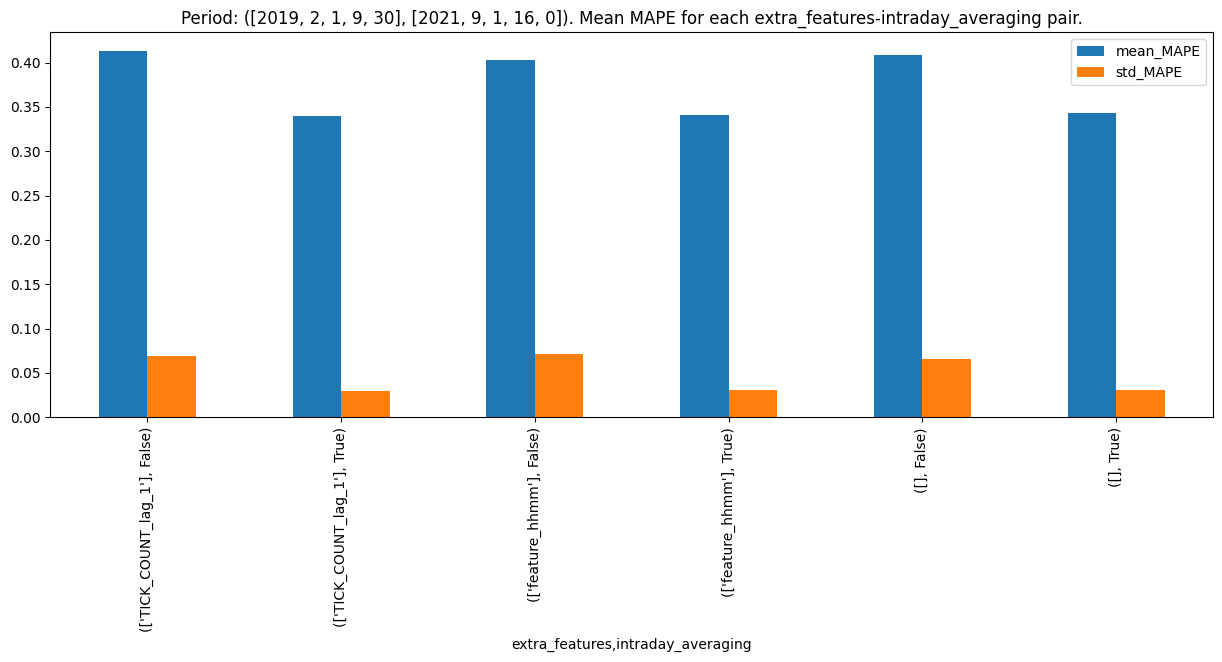

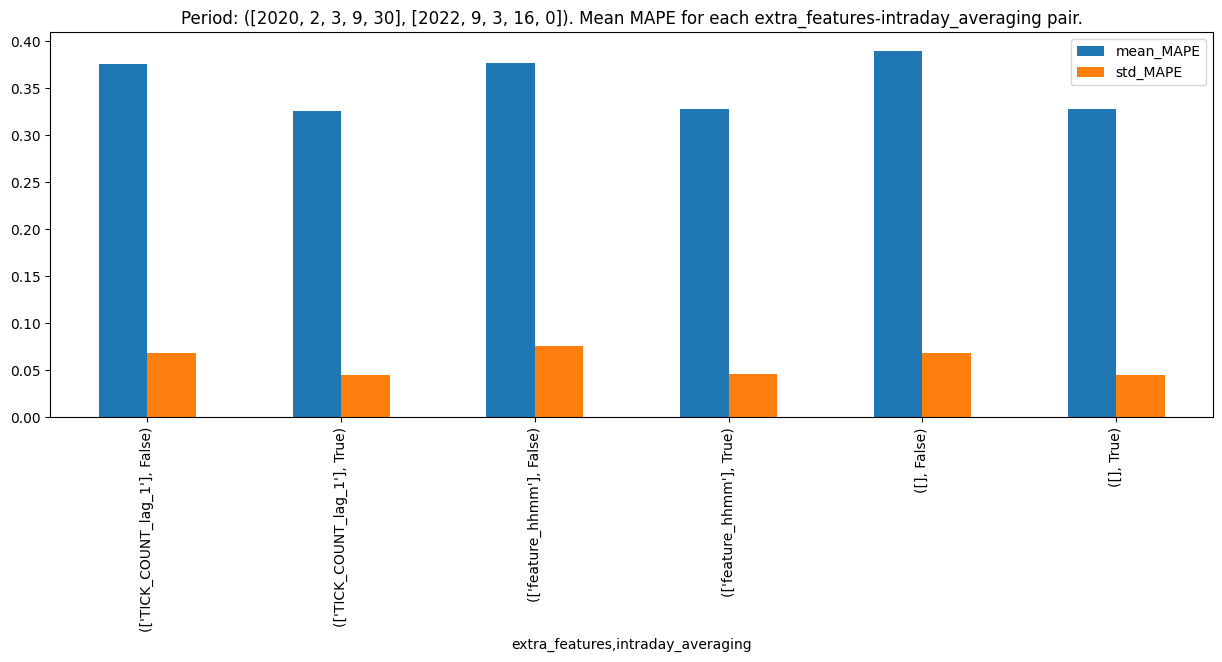

In [34]:
tdf = per_ef_ia_mape_df.reset_index()
for period in periods:
    pdf = tdf[tdf['period']==str(period)]
    pdf = pdf.set_index(['extra_features', 'intraday_averaging'])
    pdf.plot(kind='bar', figsize=[15, 5], title=f'Period: {period}. Mean MAPE for each extra_features-intraday_averaging pair.')
    plt.show()